Instanciando la red pre-entrenada VGG16 para aplicarla a la BD de personas con expansión de imágenes pero esta vez con entonación fina

## Importar librerías

In [10]:
import tensorflow as tf 
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.print(tf. __version__)

2.10.0


In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Accediendo a la BD de perros y gatos

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')
#original_dir=r"/content/drive/MyDrive/PetImages"
new_base_dir=r"human_detection_dataset"

Convierte la información de la imagen de píxeles en un tensor numérico de punto flotante y ajusta el tamaño de la imagen porque todas tienen diferente resolución.

Ajustando los datos para que todas las imágenes tengan la misma resolución y se procesen en lotes de 32 por cada pasada del algoritmo descenso de gradiente

In [14]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=32)

Found 307 files belonging to 2 classes.
Found 306 files belonging to 2 classes.
Found 308 files belonging to 2 classes.


La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas

In [7]:
# ENTONACIÓN FINA
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Transformaciones para expandir las imágenes y definición de la arquitectura


In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

## Métricas a usar

Se usará Accuracy, Recall, Precision y F1-score

In [8]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Fase de entrenamiento

In [20]:
train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    image_size=(180, 180),
    batch_size=32)

Found 307 files belonging to 2 classes.
Found 306 files belonging to 2 classes.
Found 308 files belonging to 2 classes.


Cogemos mejor modelo hasta el momento y probamos con SGD a ver como cambia

In [ ]:
v_dropout = [0.86, 0.87, 0.88, 0.89]

#Inicializar variables para realizar proceso
v_test_loss = []
v_test_acc = []
v_test_f1_score = []
v_test_precision = []
v_test_recall = []

candidate_history = []

#Iterar dropout

for dropout in v_dropout:
  #Instanciando la red pre-entrenada VGG16
  conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

  #La fase de entrenamiento podrá alterar los pesos de las n últimas capas
  n_capas_alt = 3
  conv_base.trainable = True
  for layer in conv_base.layers[:-n_capas_alt]:
      layer.trainable = False

  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.2),
      ]
  )

  #Definir arquitectura e hiperparámetros de entrenamiento
  inputs = keras.Input(shape=(180, 180, 3))
  x = keras.applications.vgg16.preprocess_input(inputs)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(dropout)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-5),
                metrics=["accuracy",f1_m,precision_m, recall_m])

  #Fase de entrenamiento

  history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset, verbose=0)
  candidate_history.append(history)

  test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
  v_test_loss.append(test_loss)
  v_test_acc.append(test_acc)
  v_test_f1_score.append(test_f1_score)
  v_test_precision.append(test_precision)
  v_test_recall.append(test_recall)

#Como arreglo
v_test_loss = np.array(v_test_loss)
v_test_acc = np.array(v_test_acc)
v_test_f1_score = np.array(v_test_f1_score)
v_test_precision = np.array(v_test_precision)
v_test_recall = np.array(v_test_recall)

#Gráficar f1_score vs dropout
plt.figure()
plt.plot(v_dropout, v_test_f1_score, marker='o', label="f1_score", color="blue")
plt.title("f1_score vs dropout")
plt.legend()
plt.show()

#Mejor resultado dropout
loc_best_result = np.where(v_test_f1_score == max(v_test_f1_score))[0][0]

#training vs validation con mejor resultado dropout
best_history = candidate_history[loc_best_result]

f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]
loss = best_history.history["loss"]
val_loss = best_history.history["val_loss"]
epochs = range(1, len(f1) + 1)

#Visualizar f1_score y pérdida con mejor resultado dropout durante entrenamiento
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(epochs, f1, "bo", label="Training f1_score")
ax1.plot(epochs, val_f1, "b", label="Validation f1_score")
ax1.set_title("Training and validation f1_score")
ax1.legend()
ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()
plt.show()

#Verificar desempeño en test con mejor resultado dropout
print("Mejores resultados: con %.2f Dropout " % v_dropout[loc_best_result])
print("test_loss: %.4f" % v_test_loss[loc_best_result])
print("test_accuracy: %.4f" % v_test_acc[loc_best_result])
print("test_f1_score: %.4f" % v_test_f1_score[loc_best_result])
print("test_precision: %.4f" % v_test_precision[loc_best_result])
print("test_recall: %.4f" % v_test_recall[loc_best_result])

Vamos a aumentar capas a ver que mejoras logramos

10/10 [==============================] - 3s 212ms/step - loss: 0.9651 - accuracy: 0.8831 - f1_m: 0.9004 - precision_m: 0.8735 - recall_m: 0.9317


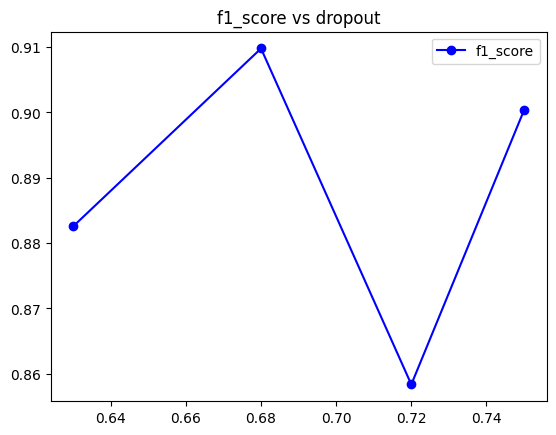

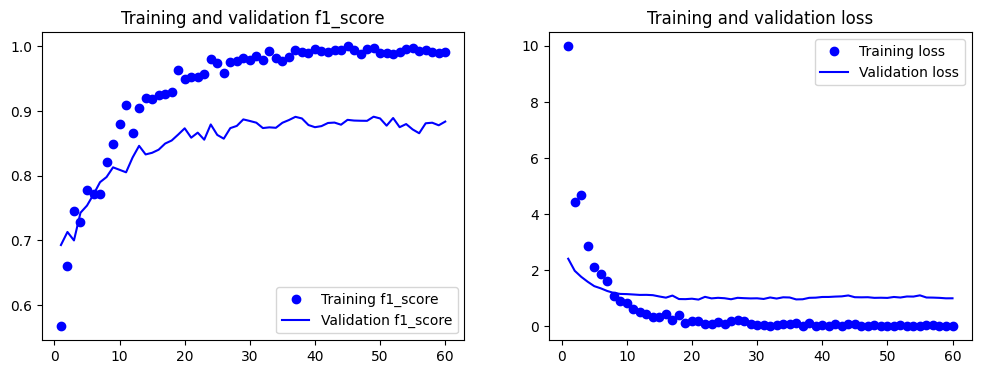

Mejores resultados: con 0.68 Dropout 
test_loss: 0.9466
test_accuracy: 0.8994
test_f1_score: 0.9098
test_precision: 0.9056
test_recall: 0.9183


In [24]:
v_dropout = [0.63, 0.68, 0.72, 0.75]

#Inicializar variables para realizar proceso
v_test_loss = []
v_test_acc = []
v_test_f1_score = []
v_test_precision = []
v_test_recall = []

candidate_history = []

#Iterar dropout

for dropout in v_dropout:
  #Instanciando la red pre-entrenada VGG16
  conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

  #La fase de entrenamiento podrá alterar los pesos de las n últimas capas
  n_capas_alt = 5
  conv_base.trainable = True
  for layer in conv_base.layers[:-n_capas_alt]:
      layer.trainable = False

  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.2),
      ]
  )

  #Definir arquitectura e hiperparámetros de entrenamiento
  inputs = keras.Input(shape=(180, 180, 3))
  x = keras.applications.vgg16.preprocess_input(inputs)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(dropout)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                metrics=["accuracy",f1_m,precision_m, recall_m])

  #Fase de entrenamiento

  history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset, verbose=0)
  candidate_history.append(history)

  test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
  v_test_loss.append(test_loss)
  v_test_acc.append(test_acc)
  v_test_f1_score.append(test_f1_score)
  v_test_precision.append(test_precision)
  v_test_recall.append(test_recall)

#Como arreglo
v_test_loss = np.array(v_test_loss)
v_test_acc = np.array(v_test_acc)
v_test_f1_score = np.array(v_test_f1_score)
v_test_precision = np.array(v_test_precision)
v_test_recall = np.array(v_test_recall)

#Gráficar f1_score vs dropout
plt.figure()
plt.plot(v_dropout, v_test_f1_score, marker='o', label="f1_score", color="blue")
plt.title("f1_score vs dropout")
plt.legend()
plt.show()

#Mejor resultado dropout
loc_best_result = np.where(v_test_f1_score == max(v_test_f1_score))[0][0]

#training vs validation con mejor resultado dropout
best_history = candidate_history[loc_best_result]

f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]
loss = best_history.history["loss"]
val_loss = best_history.history["val_loss"]
epochs = range(1, len(f1) + 1)

#Visualizar f1_score y pérdida con mejor resultado dropout durante entrenamiento
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(epochs, f1, "bo", label="Training f1_score")
ax1.plot(epochs, val_f1, "b", label="Validation f1_score")
ax1.set_title("Training and validation f1_score")
ax1.legend()
ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()
plt.show()

#Verificar desempeño en test con mejor resultado dropout
print("Mejores resultados: con %.2f Dropout " % v_dropout[loc_best_result])
print("test_loss: %.4f" % v_test_loss[loc_best_result])
print("test_accuracy: %.4f" % v_test_acc[loc_best_result])
print("test_f1_score: %.4f" % v_test_f1_score[loc_best_result])
print("test_precision: %.4f" % v_test_precision[loc_best_result])
print("test_recall: %.4f" % v_test_recall[loc_best_result])

Disminuimos aún más las capas de fine tuning, ajuste de dropout aún mas fino

10/10 [==============================] - 3s 203ms/step - loss: 1.8316 - accuracy: 0.8799 - f1_m: 0.9001 - precision_m: 0.9178 - recall_m: 0.8857


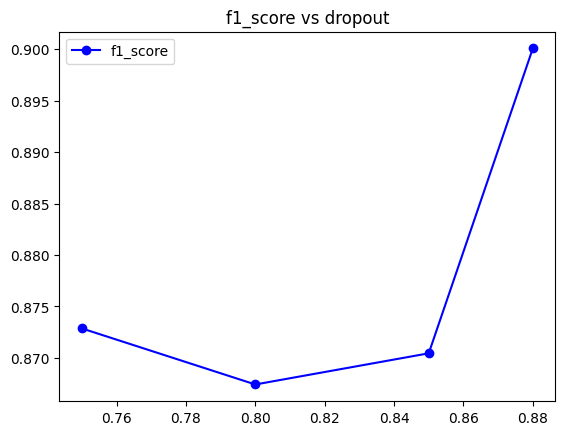

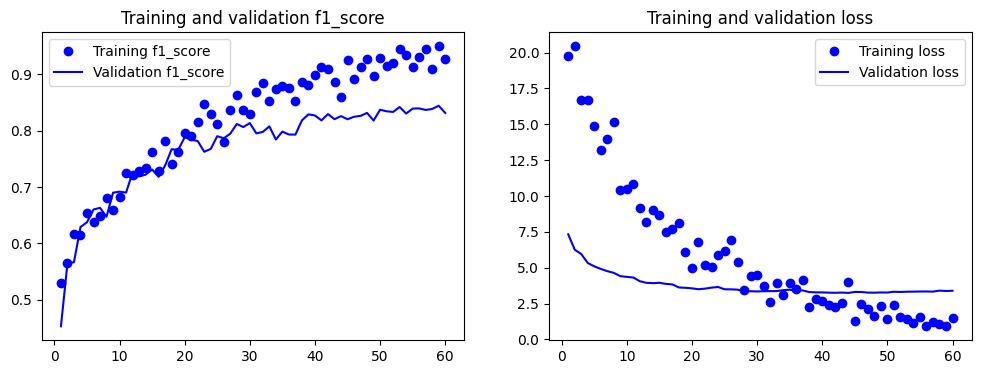

Mejores resultados: con 0.88 Dropout 
test_loss: 1.8316
test_accuracy: 0.8799
test_f1_score: 0.9001
test_precision: 0.9178
test_recall: 0.8857


In [22]:
v_dropout = [0.75, 0.8, 0.85, 0.88]

#Inicializar variables para realizar proceso
v_test_loss = []
v_test_acc = []
v_test_f1_score = []
v_test_precision = []
v_test_recall = []

candidate_history = []

#Iterar dropout

for dropout in v_dropout:
  #Instanciando la red pre-entrenada VGG16
  conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

  #La fase de entrenamiento podrá alterar los pesos de las n últimas capas
  n_capas_alt = 2
  conv_base.trainable = True
  for layer in conv_base.layers[:-n_capas_alt]:
      layer.trainable = False

  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.2),
      ]
  )

  #Definir arquitectura e hiperparámetros de entrenamiento
  inputs = keras.Input(shape=(180, 180, 3))
  x = keras.applications.vgg16.preprocess_input(inputs)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(dropout)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                metrics=["accuracy",f1_m,precision_m, recall_m])

  #Fase de entrenamiento

  history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset, verbose=0)
  candidate_history.append(history)

  test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
  v_test_loss.append(test_loss)
  v_test_acc.append(test_acc)
  v_test_f1_score.append(test_f1_score)
  v_test_precision.append(test_precision)
  v_test_recall.append(test_recall)

#Como arreglo
v_test_loss = np.array(v_test_loss)
v_test_acc = np.array(v_test_acc)
v_test_f1_score = np.array(v_test_f1_score)
v_test_precision = np.array(v_test_precision)
v_test_recall = np.array(v_test_recall)

#Gráficar f1_score vs dropout
plt.figure()
plt.plot(v_dropout, v_test_f1_score, marker='o', label="f1_score", color="blue")
plt.title("f1_score vs dropout")
plt.legend()
plt.show()

#Mejor resultado dropout
loc_best_result = np.where(v_test_f1_score == max(v_test_f1_score))[0][0]

#training vs validation con mejor resultado dropout
best_history = candidate_history[loc_best_result]

f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]
loss = best_history.history["loss"]
val_loss = best_history.history["val_loss"]
epochs = range(1, len(f1) + 1)

#Visualizar f1_score y pérdida con mejor resultado dropout durante entrenamiento
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(epochs, f1, "bo", label="Training f1_score")
ax1.plot(epochs, val_f1, "b", label="Validation f1_score")
ax1.set_title("Training and validation f1_score")
ax1.legend()
ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()
plt.show()

#Verificar desempeño en test con mejor resultado dropout
print("Mejores resultados: con %.2f Dropout " % v_dropout[loc_best_result])
print("test_loss: %.4f" % v_test_loss[loc_best_result])
print("test_accuracy: %.4f" % v_test_acc[loc_best_result])
print("test_f1_score: %.4f" % v_test_f1_score[loc_best_result])
print("test_precision: %.4f" % v_test_precision[loc_best_result])
print("test_recall: %.4f" % v_test_recall[loc_best_result])

Cambiamos las capas del fine tuning, tomamos mejor modelo con un ajuste de dropout mas fino

10/10 [==============================] - 3s 202ms/step - loss: 0.7839 - accuracy: 0.9123 - f1_m: 0.9259 - precision_m: 0.8980 - recall_m: 0.9580


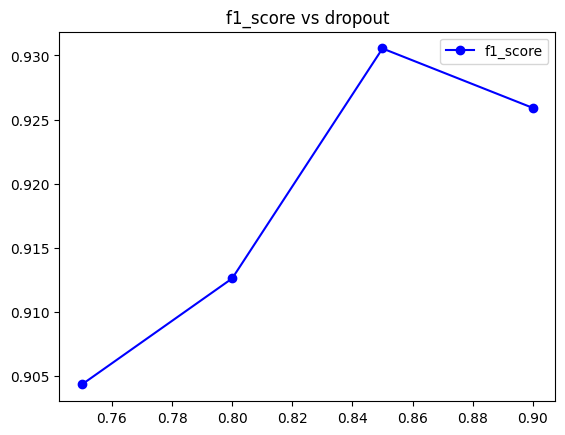

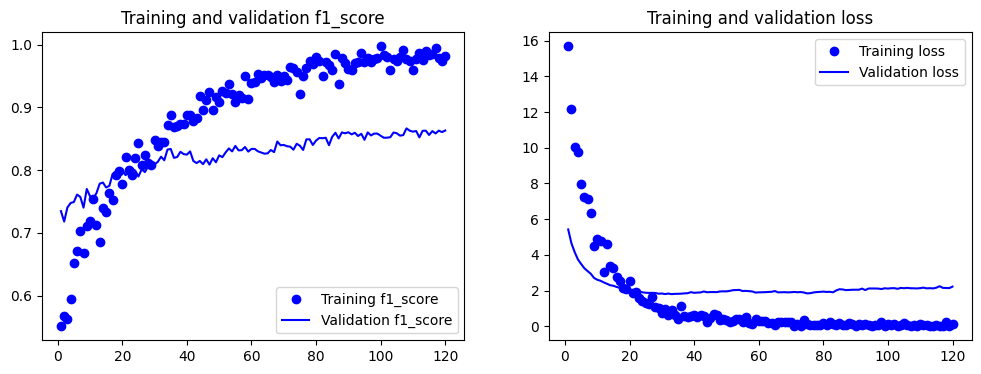

Mejores resultados: con 0.85 Dropout 
test_loss: 1.2495
test_accuracy: 0.9156
test_f1_score: 0.9305
test_precision: 0.9332
test_recall: 0.9306


In [26]:
v_dropout = [0.75, 0.8, 0.85, 0.9]

#Inicializar variables para realizar proceso
v_test_loss = []
v_test_acc = []
v_test_f1_score = []
v_test_precision = []
v_test_recall = []

candidate_history = []

#Iterar dropout

for dropout in v_dropout:
  #Instanciando la red pre-entrenada VGG16
  conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

  #La fase de entrenamiento podrá alterar los pesos de las n últimas capas
  n_capas_alt = 3
  conv_base.trainable = True
  for layer in conv_base.layers[:-n_capas_alt]:
      layer.trainable = False

  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.2),
      ]
  )

  #Definir arquitectura e hiperparámetros de entrenamiento
  inputs = keras.Input(shape=(180, 180, 3))
  x = keras.applications.vgg16.preprocess_input(inputs)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(dropout)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                metrics=["accuracy",f1_m,precision_m, recall_m])

  #Fase de entrenamiento

  history = model.fit(
    train_dataset,
    epochs=120,
    validation_data=validation_dataset, verbose=0)
  candidate_history.append(history)

  test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
  v_test_loss.append(test_loss)
  v_test_acc.append(test_acc)
  v_test_f1_score.append(test_f1_score)
  v_test_precision.append(test_precision)
  v_test_recall.append(test_recall)

#Como arreglo
v_test_loss = np.array(v_test_loss)
v_test_acc = np.array(v_test_acc)
v_test_f1_score = np.array(v_test_f1_score)
v_test_precision = np.array(v_test_precision)
v_test_recall = np.array(v_test_recall)

#Gráficar f1_score vs dropout
plt.figure()
plt.plot(v_dropout, v_test_f1_score, marker='o', label="f1_score", color="blue")
plt.title("f1_score vs dropout")
plt.legend()
plt.show()

#Mejor resultado dropout
loc_best_result = np.where(v_test_f1_score == max(v_test_f1_score))[0][0]

#training vs validation con mejor resultado dropout
best_history = candidate_history[loc_best_result]

f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]
loss = best_history.history["loss"]
val_loss = best_history.history["val_loss"]
epochs = range(1, len(f1) + 1)

#Visualizar f1_score y pérdida con mejor resultado dropout durante entrenamiento
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(epochs, f1, "bo", label="Training f1_score")
ax1.plot(epochs, val_f1, "b", label="Validation f1_score")
ax1.set_title("Training and validation f1_score")
ax1.legend()
ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()
plt.show()

#Verificar desempeño en test con mejor resultado dropout
print("Mejores resultados: con %.2f Dropout " % v_dropout[loc_best_result])
print("test_loss: %.4f" % v_test_loss[loc_best_result])
print("test_accuracy: %.4f" % v_test_acc[loc_best_result])
print("test_f1_score: %.4f" % v_test_f1_score[loc_best_result])
print("test_precision: %.4f" % v_test_precision[loc_best_result])
print("test_recall: %.4f" % v_test_recall[loc_best_result])

Cambiamos batch size a 16

Resultados evidencian que es necesario aumentar también el número de épocas

20/20 [==============================] - 3s 119ms/step - loss: 0.6226 - accuracy: 0.8994 - f1_m: 0.9066 - precision_m: 0.9013 - recall_m: 0.9151


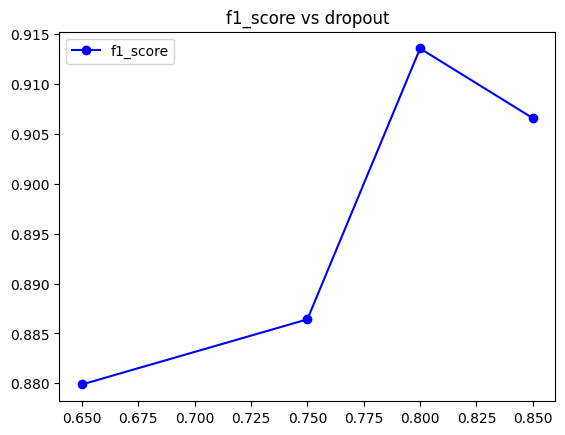

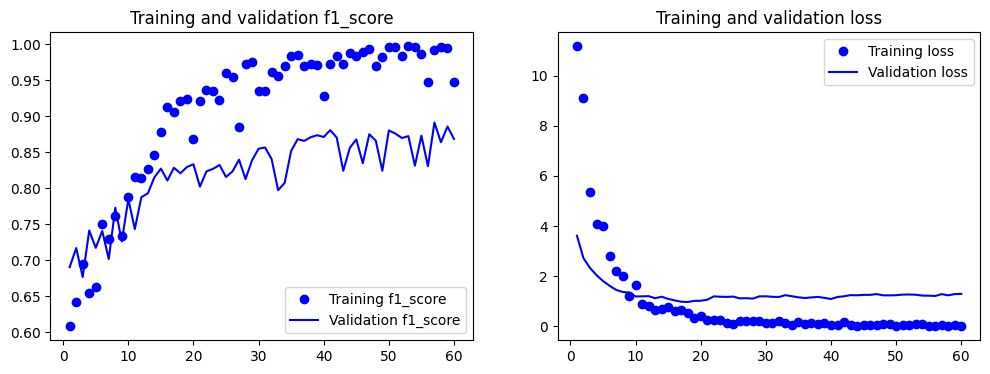

Mejores resultados: con 0.80 Dropout 
test_loss: 1.0013
test_accuracy: 0.8994
test_f1_score: 0.9135
test_precision: 0.9364
test_recall: 0.9026


In [19]:
v_dropout = [0.65, 0.75, 0.8, 0.85]

#Inicializar variables para realizar proceso
v_test_loss = []
v_test_acc = []
v_test_f1_score = []
v_test_precision = []
v_test_recall = []

candidate_history = []

#Iterar dropout

for dropout in v_dropout:
  #Instanciando la red pre-entrenada VGG16
  conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

  #La fase de entrenamiento podrá alterar los pesos de las n últimas capas
  n_capas_alt = 4
  conv_base.trainable = True
  for layer in conv_base.layers[:-n_capas_alt]:
      layer.trainable = False

  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.2),
      ]
  )

  #Definir arquitectura e hiperparámetros de entrenamiento
  inputs = keras.Input(shape=(180, 180, 3))
  x = keras.applications.vgg16.preprocess_input(inputs)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(dropout)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                metrics=["accuracy",f1_m,precision_m, recall_m])

  #Fase de entrenamiento

  history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset, verbose=0)
  candidate_history.append(history)

  test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
  v_test_loss.append(test_loss)
  v_test_acc.append(test_acc)
  v_test_f1_score.append(test_f1_score)
  v_test_precision.append(test_precision)
  v_test_recall.append(test_recall)

#Como arreglo
v_test_loss = np.array(v_test_loss)
v_test_acc = np.array(v_test_acc)
v_test_f1_score = np.array(v_test_f1_score)
v_test_precision = np.array(v_test_precision)
v_test_recall = np.array(v_test_recall)

#Gráficar f1_score vs dropout
plt.figure()
plt.plot(v_dropout, v_test_f1_score, marker='o', label="f1_score", color="blue")
plt.title("f1_score vs dropout")
plt.legend()
plt.show()

#Mejor resultado dropout
loc_best_result = np.where(v_test_f1_score == max(v_test_f1_score))[0][0]

#training vs validation con mejor resultado dropout
best_history = candidate_history[loc_best_result]

f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]
loss = best_history.history["loss"]
val_loss = best_history.history["val_loss"]
epochs = range(1, len(f1) + 1)

#Visualizar f1_score y pérdida con mejor resultado dropout durante entrenamiento
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(epochs, f1, "bo", label="Training f1_score")
ax1.plot(epochs, val_f1, "b", label="Validation f1_score")
ax1.set_title("Training and validation f1_score")
ax1.legend()
ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()
plt.show()

#Verificar desempeño en test con mejor resultado dropout
print("Mejores resultados: con %.2f Dropout " % v_dropout[loc_best_result])
print("test_loss: %.4f" % v_test_loss[loc_best_result])
print("test_accuracy: %.4f" % v_test_acc[loc_best_result])
print("test_f1_score: %.4f" % v_test_f1_score[loc_best_result])
print("test_precision: %.4f" % v_test_precision[loc_best_result])
print("test_recall: %.4f" % v_test_recall[loc_best_result])

Más experimentos para definir dropout

10/10 [==============================] - 3s 201ms/step - loss: 0.8776 - accuracy: 0.9123 - f1_m: 0.9265 - precision_m: 0.9168 - recall_m: 0.9402


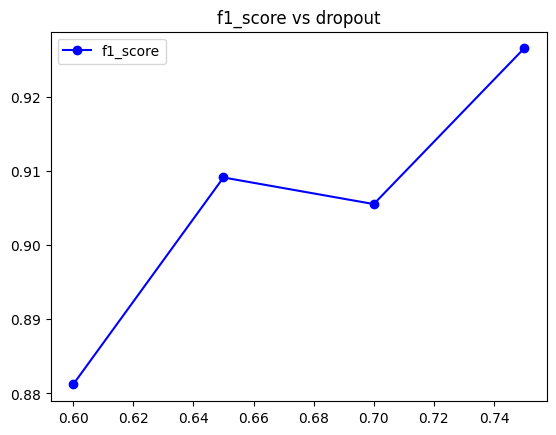

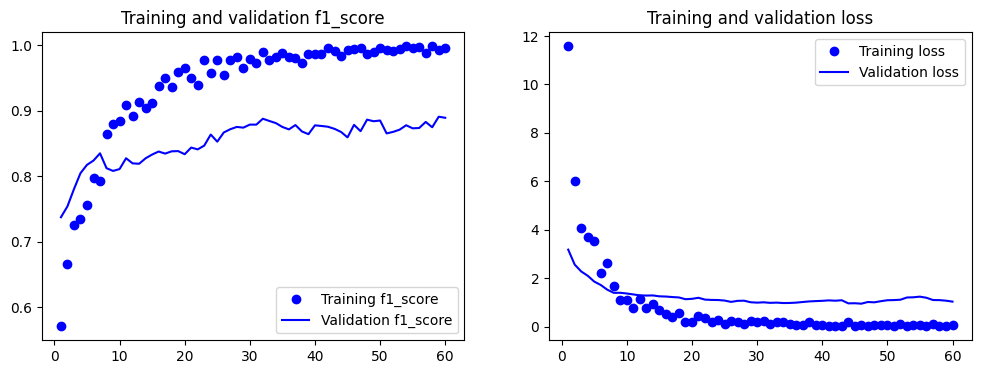

Mejores resultados: con 0.75 Dropout 
test_loss: 0.8776
test_accuracy: 0.9123
test_f1_score: 0.9265
test_precision: 0.9168
test_recall: 0.9402


In [17]:
v_dropout = [0.6, 0.65, 0.7, 0.75]

#Inicializar variables para realizar proceso
v_test_loss = []
v_test_acc = []
v_test_f1_score = []
v_test_precision = []
v_test_recall = []

candidate_history = []

#Iterar dropout

for dropout in v_dropout:
  #Instanciando la red pre-entrenada VGG16
  conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

  #La fase de entrenamiento podrá alterar los pesos de las n últimas capas
  n_capas_alt = 4
  conv_base.trainable = True
  for layer in conv_base.layers[:-n_capas_alt]:
      layer.trainable = False

  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.2),
      ]
  )

  #Definir arquitectura e hiperparámetros de entrenamiento
  inputs = keras.Input(shape=(180, 180, 3))
  x = keras.applications.vgg16.preprocess_input(inputs)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(dropout)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                metrics=["accuracy",f1_m,precision_m, recall_m])

  #Fase de entrenamiento

  history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset, verbose=0)
  candidate_history.append(history)

  test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
  v_test_loss.append(test_loss)
  v_test_acc.append(test_acc)
  v_test_f1_score.append(test_f1_score)
  v_test_precision.append(test_precision)
  v_test_recall.append(test_recall)

#Como arreglo
v_test_loss = np.array(v_test_loss)
v_test_acc = np.array(v_test_acc)
v_test_f1_score = np.array(v_test_f1_score)
v_test_precision = np.array(v_test_precision)
v_test_recall = np.array(v_test_recall)

#Gráficar f1_score vs dropout
plt.figure()
plt.plot(v_dropout, v_test_f1_score, marker='o', label="f1_score", color="blue")
plt.title("f1_score vs dropout")
plt.legend()
plt.show()

#Mejor resultado dropout
loc_best_result = np.where(v_test_f1_score == max(v_test_f1_score))[0][0]

#training vs validation con mejor resultado dropout
best_history = candidate_history[loc_best_result]

f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]
loss = best_history.history["loss"]
val_loss = best_history.history["val_loss"]
epochs = range(1, len(f1) + 1)

#Visualizar f1_score y pérdida con mejor resultado dropout durante entrenamiento
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(epochs, f1, "bo", label="Training f1_score")
ax1.plot(epochs, val_f1, "b", label="Validation f1_score")
ax1.set_title("Training and validation f1_score")
ax1.legend()
ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()
plt.show()

#Verificar desempeño en test con mejor resultado dropout
print("Mejores resultados: con %.2f Dropout " % v_dropout[loc_best_result])
print("test_loss: %.4f" % v_test_loss[loc_best_result])
print("test_accuracy: %.4f" % v_test_acc[loc_best_result])
print("test_f1_score: %.4f" % v_test_f1_score[loc_best_result])
print("test_precision: %.4f" % v_test_precision[loc_best_result])
print("test_recall: %.4f" % v_test_recall[loc_best_result])

10/10 [==============================] - 3s 201ms/step - loss: 0.6702 - accuracy: 0.6396 - f1_m: 0.7137 - precision_m: 0.6901 - recall_m: 0.7440


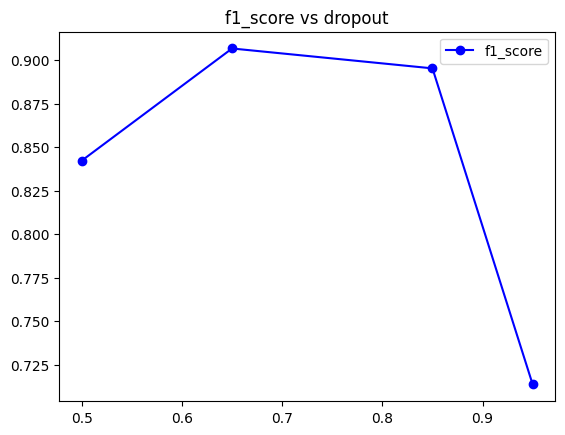

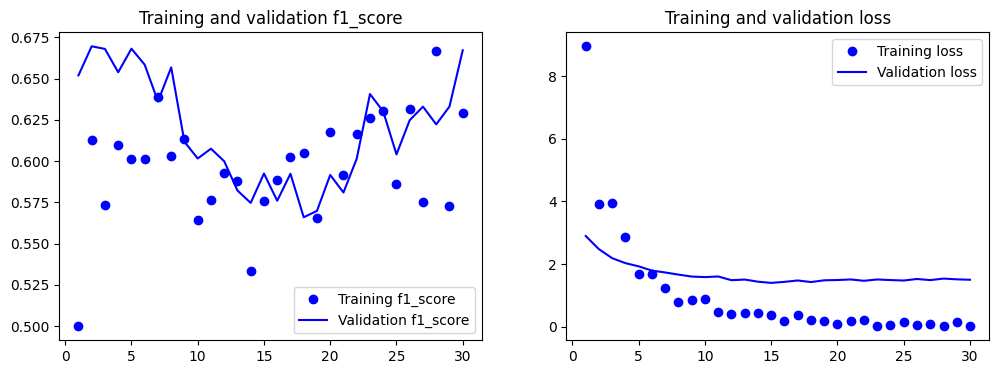

Mejores resultados: con 0.65 Dropout 
test_loss: 0.8552
test_accuracy: 0.8929
test_f1_score: 0.9066
test_precision: 0.9053
test_recall: 0.9096


In [16]:
v_dropout = [0.5, 0.65, 0.85, 0.95]

#Inicializar variables para realizar proceso
v_test_loss = []
v_test_acc = []
v_test_f1_score = []
v_test_precision = []
v_test_recall = []

candidate_history = []

#Iterar dropout

for dropout in v_dropout:
  #Instanciando la red pre-entrenada VGG16
  conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

  #La fase de entrenamiento podrá alterar los pesos de las n últimas capas
  n_capas_alt = 4
  conv_base.trainable = True
  for layer in conv_base.layers[:-n_capas_alt]:
      layer.trainable = False

  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.2),
      ]
  )

  #Definir arquitectura e hiperparámetros de entrenamiento
  inputs = keras.Input(shape=(180, 180, 3))
  x = keras.applications.vgg16.preprocess_input(inputs)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(dropout)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                metrics=["accuracy",f1_m,precision_m, recall_m])

  #Fase de entrenamiento

  history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset, verbose=0)
  candidate_history.append(history)

  test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
  v_test_loss.append(test_loss)
  v_test_acc.append(test_acc)
  v_test_f1_score.append(test_f1_score)
  v_test_precision.append(test_precision)
  v_test_recall.append(test_recall)

#Como arreglo
v_test_loss = np.array(v_test_loss)
v_test_acc = np.array(v_test_acc)
v_test_f1_score = np.array(v_test_f1_score)
v_test_precision = np.array(v_test_precision)
v_test_recall = np.array(v_test_recall)

#Gráficar f1_score vs dropout
plt.figure()
plt.plot(v_dropout, v_test_f1_score, marker='o', label="f1_score", color="blue")
plt.title("f1_score vs dropout")
plt.legend()
plt.show()

#Mejor resultado dropout
loc_best_result = np.where(v_test_f1_score == max(v_test_f1_score))[0][0]

#training vs validation con mejor resultado dropout
best_history = candidate_history[loc_best_result]

f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]
loss = best_history.history["loss"]
val_loss = best_history.history["val_loss"]
epochs = range(1, len(f1) + 1)

#Visualizar f1_score y pérdida con mejor resultado dropout durante entrenamiento
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(epochs, f1, "bo", label="Training f1_score")
ax1.plot(epochs, val_f1, "b", label="Validation f1_score")
ax1.set_title("Training and validation f1_score")
ax1.legend()
ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()
plt.show()

#Verificar desempeño en test con mejor resultado dropout
print("Mejores resultados: con %.2f Dropout " % v_dropout[loc_best_result])
print("test_loss: %.4f" % v_test_loss[loc_best_result])
print("test_accuracy: %.4f" % v_test_acc[loc_best_result])
print("test_f1_score: %.4f" % v_test_f1_score[loc_best_result])
print("test_precision: %.4f" % v_test_precision[loc_best_result])
print("test_recall: %.4f" % v_test_recall[loc_best_result])

Primeros experimentos

10/10 [==============================] - 3s 201ms/step - loss: 0.7615 - accuracy: 0.8377 - f1_m: 0.8723 - precision_m: 0.8668 - recall_m: 0.8841


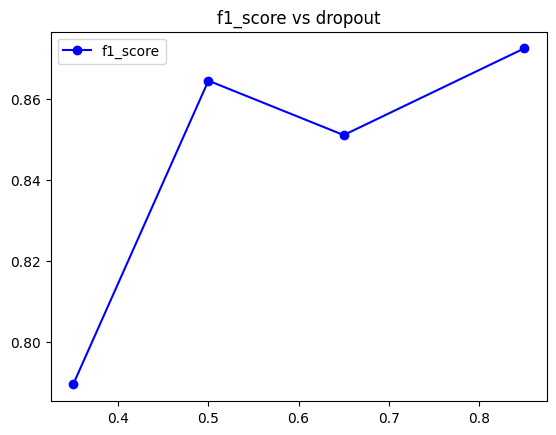

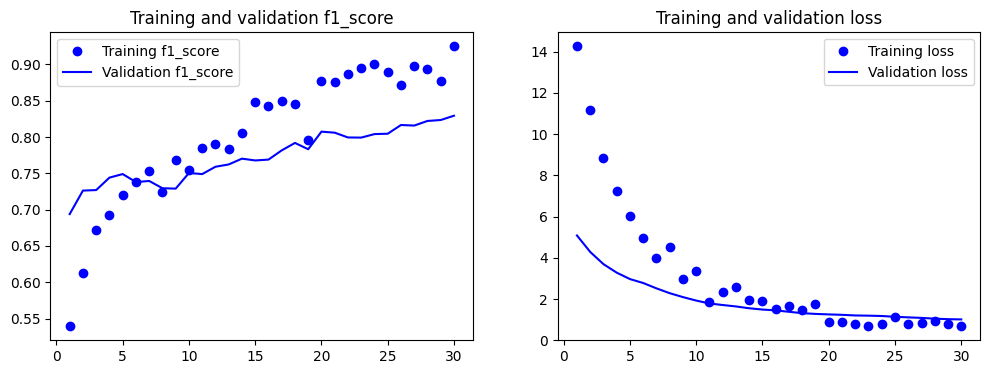

Mejores resultados: con 0.85 Dropout 
test_loss: 0.7615
test_accuracy: 0.8377
test_f1_score: 0.8723
test_precision: 0.8668
test_recall: 0.8841


In [12]:
v_dropout = [0.35, 0.5, 0.65, 0.85]

#Inicializar variables para realizar proceso
v_test_loss = []
v_test_acc = []
v_test_f1_score = []
v_test_precision = []
v_test_recall = []

candidate_history = []

#Iterar dropout

for dropout in v_dropout:
  #Instanciando la red pre-entrenada VGG16
  conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

  #La fase de entrenamiento podrá alterar los pesos de las n últimas capas
  n_capas_alt = 4
  conv_base.trainable = True
  for layer in conv_base.layers[:-n_capas_alt]:
      layer.trainable = False

  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
          layers.RandomZoom(0.2),
      ]
  )

  #Definir arquitectura e hiperparámetros de entrenamiento
  inputs = keras.Input(shape=(180, 180, 3))
  x = keras.applications.vgg16.preprocess_input(inputs)
  x = conv_base(x)
  x = layers.Flatten()(x)
  x = layers.Dense(256)(x)
  x = layers.Dropout(dropout)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                metrics=["accuracy",f1_m,precision_m, recall_m])

  #Fase de entrenamiento

  history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset, verbose=0)
  candidate_history.append(history)

  test_loss, test_acc, test_f1_score, test_precision, test_recall = model.evaluate(test_dataset)
  v_test_loss.append(test_loss)
  v_test_acc.append(test_acc)
  v_test_f1_score.append(test_f1_score)
  v_test_precision.append(test_precision)
  v_test_recall.append(test_recall)

#Como arreglo
v_test_loss = np.array(v_test_loss)
v_test_acc = np.array(v_test_acc)
v_test_f1_score = np.array(v_test_f1_score)
v_test_precision = np.array(v_test_precision)
v_test_recall = np.array(v_test_recall)

#Gráficar f1_score vs dropout
plt.figure()
plt.plot(v_dropout, v_test_f1_score, marker='o', label="f1_score", color="blue")
plt.title("f1_score vs dropout")
plt.legend()
plt.show()

#Mejor resultado dropout
loc_best_result = np.where(v_test_f1_score == max(v_test_f1_score))[0][0]

#training vs validation con mejor resultado dropout
best_history = candidate_history[loc_best_result]

f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]
loss = best_history.history["loss"]
val_loss = best_history.history["val_loss"]
epochs = range(1, len(f1) + 1)

#Visualizar f1_score y pérdida con mejor resultado dropout durante entrenamiento
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(epochs, f1, "bo", label="Training f1_score")
ax1.plot(epochs, val_f1, "b", label="Validation f1_score")
ax1.set_title("Training and validation f1_score")
ax1.legend()
ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.legend()
plt.show()

#Verificar desempeño en test con mejor resultado dropout
print("Mejores resultados: con %.2f Dropout " % v_dropout[loc_best_result])
print("test_loss: %.4f" % v_test_loss[loc_best_result])
print("test_accuracy: %.4f" % v_test_acc[loc_best_result])
print("test_f1_score: %.4f" % v_test_f1_score[loc_best_result])
print("test_precision: %.4f" % v_test_precision[loc_best_result])
print("test_recall: %.4f" % v_test_recall[loc_best_result])